# 8. Image operations: FFT- vs interpolation-based methods

> Author: *Valentin Christiaens*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2024/03/26* 

**Table of contents**

* [8.1. Loading data and modules](#8.1.-Loading-data-and-modules)
* [8.2. Rotation](#8.2.-Rotation)
    - [8.2.1. Interpolation-based methods](#8.2.1.-Interpolation-based-methods)
    - [8.2.2. FT-based method](#8.2.2.-FT-based-method)
    - [8.2.3. Edge-blending](#8.2.3.-Edge-blending)
* [8.3. Scaling](#8.3.-Scaling)
    - [8.3.1. Interpolation-based methods](#8.3.1.-Interpolation-based-methods)
    - [8.3.2. FT-based method](#8.3.2.-FT-based-method)
* [8.4. Shifts](#8.4.-Shifts)

This tutorial shows a quantitative comparison between FFT-based and interpolation-based methods for:

- image rotations;
- image scaling;
- sub-px shifts.

-----------

Image centering at sub-px accuracy is a crucial pre-processing step as seen in Section 2.
Moreover, all post-processing algorithms based on angular differential imaging involve the rotation of images, while spectral differential imaging involve the scaling of images. 
It is therefore useful to take a little detour to understand how these operations are made in practice.
Two main types of methods exist to shift, scale or rotate images by arbitrary amounts: 

1) interpolation-based methods;
    
2) Fourier-transform based methods (i.e. operation done in the Fourier plane). 

<font color='orange'> **Question 8.1**: Which of the two kinds of method is expected to be the most accurate to preserve the total flux and its distribution in the image?</font> 

To answer this question, let's consider the mean image of the NACO observation of Beta Pic b as test image.

## 8.1. Loading data and modules

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we check that your version of VIP passes the requirements to run this notebook:

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) <= version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be strictly above 1.0.3 to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.1


<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

Some of the tests in this notebook will require the installation of `opencv` (optional dependency of VIP -- if needed: `pip install opencv-python`). The notebook will still run if you do not install it, but some cells will not be processed.
</div>

We define the `nocv2` variable to know whether `opencv` is installed or not:

In [3]:
try:
    import cv2
    nocv2=False
except:
    nocv2=True

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

In [4]:
from vip_hci.fits import open_fits
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/naco_betapic_cube_cen.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube_cen.fits'

cube = open_fits(f1)

test_image = cube.mean(axis=0)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)


<font color=green> **Answer 8.1:** The tests shown in this section demonstrate the superiority of the FT-based method over interpolation-based methods in order to preserve the flux present in the image. Since the method only relies on applying phase factors to the Fourier transform, the almost perfect flux preservation is a direct consequence of Parseval's theorem (total power preserved in image and Fourier planes). </font>

## 8.2. Rotation

To evaluate how well the flux is preserved by interpolation-based and FFT-based methods, we rotate the image 72 times by 5deg (=360deg), and compare the resulting image to the original image. The available options for `imlib` in the case of *image rotation* (i.e. in all ADI-based functions) are:

- `'opencv'` to use the `opencv` python package (optional dependence which must be installed separately);
- `'skimage'` to use functions of the `scikit-image` package;
- `'vip-fft'` to use the FFT-based rotation method desribed in Larkin et al. (1997) and implemented in VIP (default).

If imlib is set to `opencv` or `skimage`, the `interpolation` argument will set the degree of interpolation to be used - check the description of `vip.preproc.frame_rotate` for all available options.

### 8.2.1. Interpolation-based methods

The most common way to rotate an image involves inferring pixel intensities in the rotated/shifted image based on interpolation of the original grid of pixel intensities. Different kernels of increasing complexity/order can be used for the interpolation.

Let's first test different interpolation orders with the `skimage` package.

In [5]:
from vip_hci.preproc import frame_rotate
from vip_hci.config import time_ini, timing

imlib_test = 'skimage'

test_image_rot_bil = test_image.copy()
test_image_rot_bic = test_image.copy()
test_image_rot_biq = test_image.copy()
test_image_rot_biq5 = test_image.copy()

print("*** Bilinear ({}) test ***".format(imlib_test))
t0 = time_ini(False)
for i in range(72):
    test_image_rot_bil = frame_rotate(test_image_rot_bil , 5, imlib=imlib_test, interpolation='bilinear')
timing(t0) 
    
print("*** Bicubic ({}) test ***".format(imlib_test))
t0 = time_ini(False)
for i in range(72):
    test_image_rot_bic = frame_rotate(test_image_rot_bic, 5, imlib=imlib_test, interpolation='bicubic')
timing(t0) 

print("*** Biquartic (skimage) test ***")
t0 = time_ini(False)
for i in range(72):
    test_image_rot_biq = frame_rotate(test_image_rot_biq, 5, imlib='skimage', interpolation='biquartic')
timing(t0)
   
print("*** Biquintic (skimage) test ***")
t0 = time_ini(False)
for i in range(72):
    test_image_rot_biq5 = frame_rotate(test_image_rot_biq5, 5, imlib='skimage', interpolation='biquintic')
timing(t0)

*** Bilinear (skimage) test ***
Running time:  0:00:00.016784
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Bicubic (skimage) test ***
Running time:  0:00:00.024677
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Biquartic (skimage) test ***
Running time:  0:00:00.136842
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Biquintic (skimage) test ***
Running time:  0:00:00.164174
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's set the cuts for the images to be displayed

In [6]:
vmax12 = float(test_image.max())
vmax3 = 20
vmin12 = float(test_image.min())
vmin3 = -20

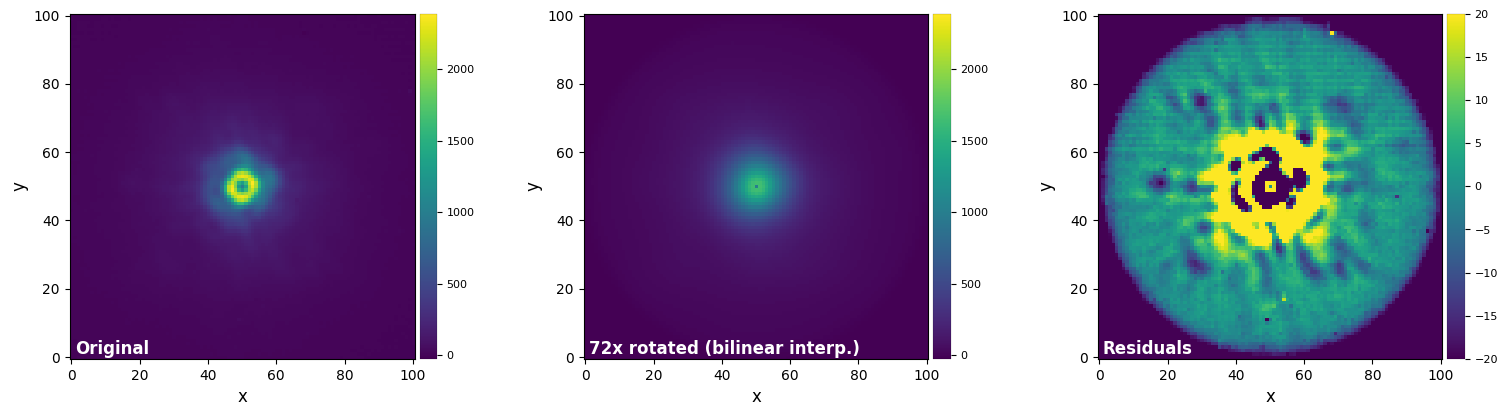

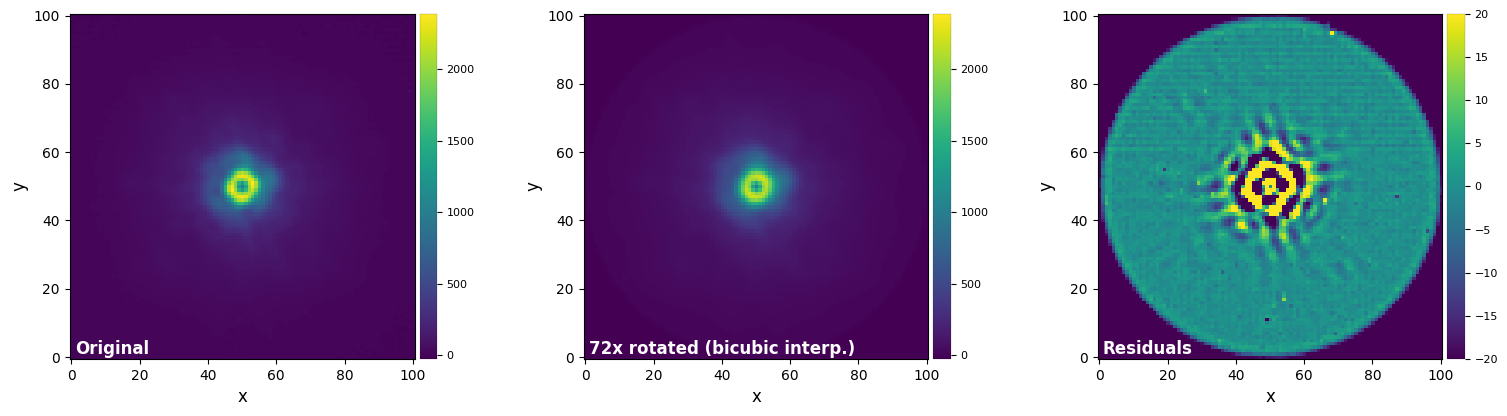

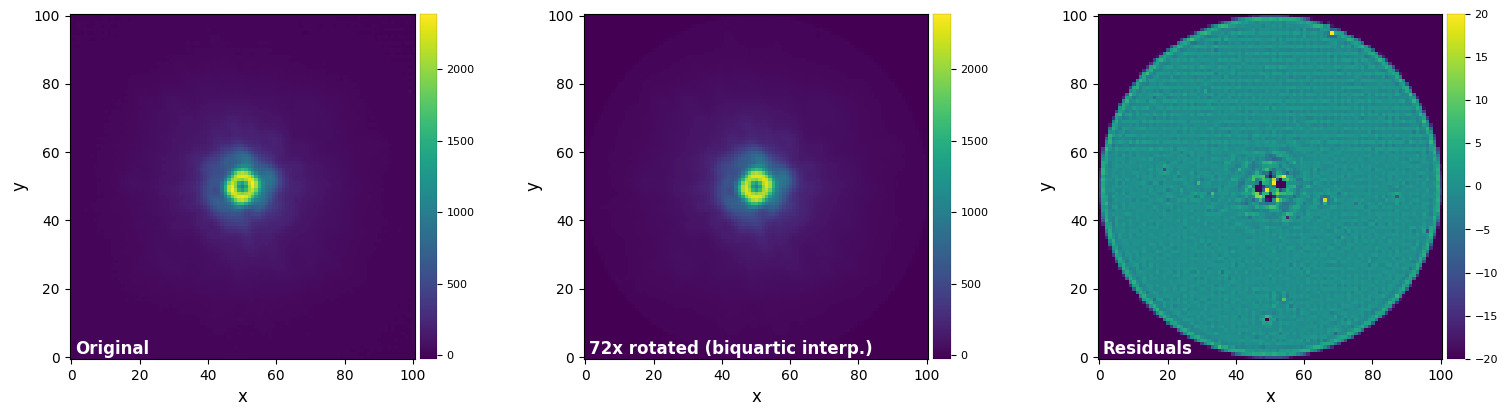

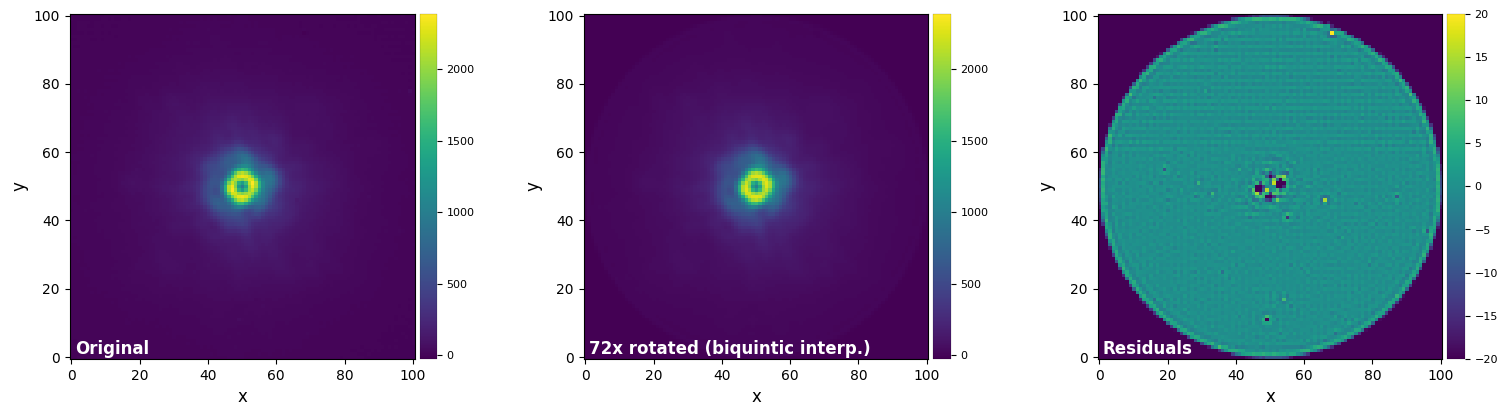

In [7]:
plot_frames((test_image, test_image_rot_bil, test_image_rot_bil-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "72x rotated (bilinear interp.)", "Residuals"))
plot_frames((test_image, test_image_rot_bic, test_image_rot_bic-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "72x rotated (bicubic interp.)", "Residuals"))
plot_frames((test_image, test_image_rot_biq, test_image_rot_biq-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "72x rotated (biquartic interp.)", "Residuals"))
plot_frames((test_image, test_image_rot_biq5, test_image_rot_biq5-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "72x rotated (biquintic interp.)", "Residuals"))

Interpolation-based methods are relatively fast, with the degree of interpolation usually setting the trade-off between flux conservation (higher orders more accurate) and speed (lower orders faster). For the test above, we see that the biquartic and biquintic results yield a good compromise between flux conservation and speed.

Let's now test interpolation-based rotation using `opencv`, if installed:

*** Bilinear (opencv) test ***
Running time:  0:00:00.008175
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Bicubic (opencv) test ***
Running time:  0:00:00.008036
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Lanczos4 (opencv) test ***
Running time:  0:00:00.024423
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


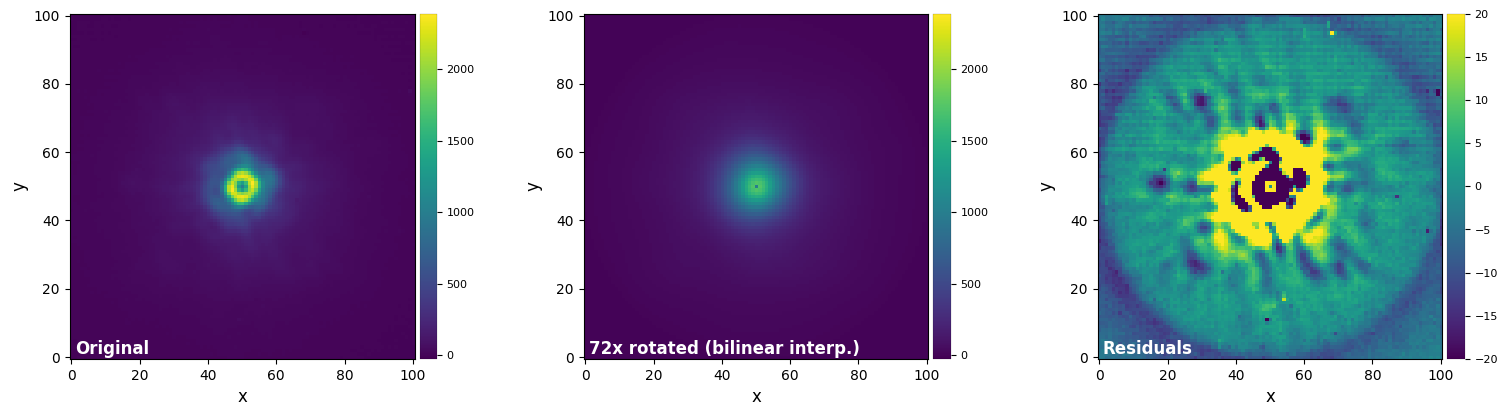

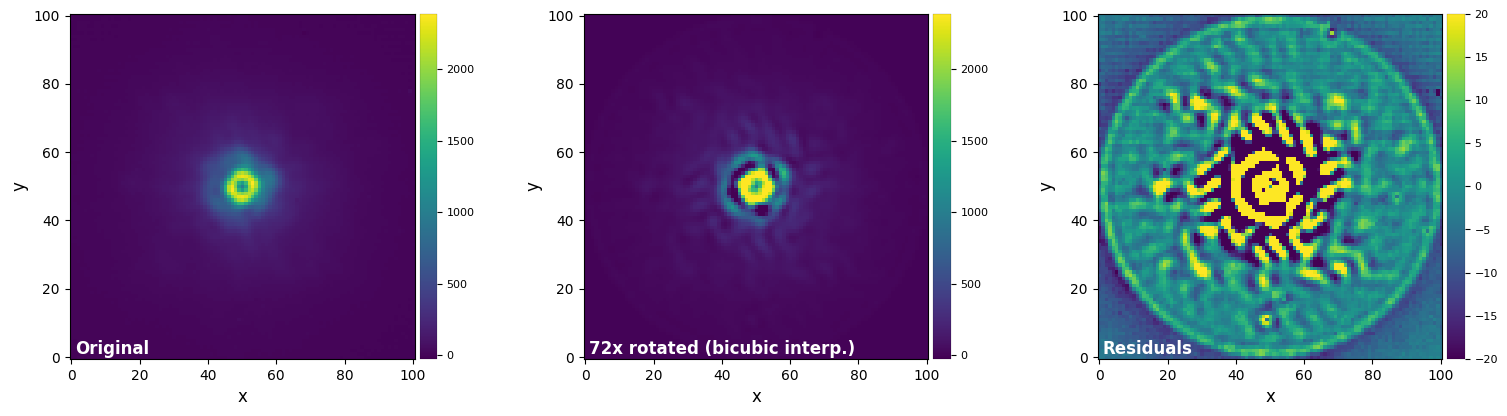

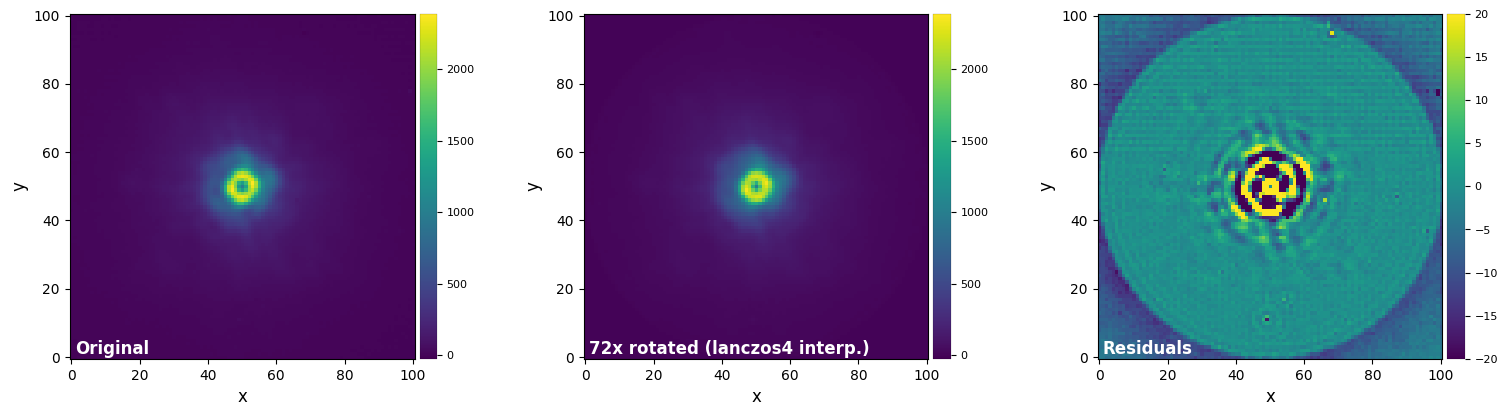

In [8]:
if not nocv2:
    imlib_test = 'opencv'

    test_image_rot_bil = test_image.copy()
    test_image_rot_bic = test_image.copy()
    test_image_rot_lzs4 = test_image.copy()

    print("*** Bilinear ({}) test ***".format(imlib_test))
    t0 = time_ini(False)
    for i in range(72):
        test_image_rot_bil = frame_rotate(test_image_rot_bil , 5, imlib=imlib_test, interpolation='bilinear')
    timing(t0) 

    print("*** Bicubic ({}) test ***".format(imlib_test))
    t0 = time_ini(False)
    for i in range(72):
        test_image_rot_bic = frame_rotate(test_image_rot_bic, 5, imlib=imlib_test, interpolation='bicubic')
    timing(t0) 

    t0 = time_ini(False)
    print("*** Lanczos4 ({}) test ***".format(imlib_test))
    for i in range(72):
        test_image_rot_lzs4 = frame_rotate(test_image_rot_lzs4, 5, imlib=imlib_test, interpolation='lanczos4')
    timing(t0)
    
    plot_frames((test_image, test_image_rot_bil, test_image_rot_bil-test_image),
                 vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
                 label = ("Original", "72x rotated (bilinear interp.)", "Residuals"))
    plot_frames((test_image, test_image_rot_bic, test_image_rot_bic-test_image),
                 vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
                 label = ("Original", "72x rotated (bicubic interp.)", "Residuals"))
    plot_frames((test_image, test_image_rot_lzs4, test_image_rot_lzs4-test_image),
                 vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
                 label = ("Original", "72x rotated (lanczos4 interp.)", "Residuals"))

Using the `opencv` library yields significantly faster speeds than `skimage`, but an overall decrease in accuracy.

Beware that in presence of high-spatial frequency or step-edge like signals (e.g. numerical or physical coronagraphic mask), higher order interpolation can lead to ringing artefacts:

In [9]:
from vip_hci.var import mask_circle

test_image_mask = mask_circle(test_image.copy(),8)
test_image_rot_bil = test_image_mask.copy()
test_image_rot_bic = test_image_mask.copy()
test_image_rot_biq4 = test_image_mask.copy()

print("*** Bilinear test ***")
t0 = time_ini(False)
for i in range(72):
    test_image_rot_bil = frame_rotate(test_image_rot_bil, 5, imlib='skimage', interpolation='bilinear')
timing(t0) 

print("*** Bicubic test ***")
t0 = time_ini(False)
for i in range(72):
    test_image_rot_bic = frame_rotate(test_image_rot_bic, 5, imlib='skimage', interpolation='bicubic')
timing(t0)

print("*** Biquartic test ***")
t0 = time_ini(False)
for i in range(72):
    test_image_rot_biq4 = frame_rotate(test_image_rot_biq4, 5, imlib='skimage', interpolation='biquartic')
timing(t0)

if not nocv2:
    test_image_rot_lzs4 = test_image_mask.copy()
    imlib_test = 'opencv'
    print("*** Lanczos4 (opencv) test ***")
    t0 = time_ini(False)
    for i in range(72):
        test_image_rot_lzs4 = frame_rotate(test_image_rot_lzs4, 5, imlib=imlib_test, interpolation='lanczos4')
    timing(t0)

*** Bilinear test ***
Running time:  0:00:00.016395
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Bicubic test ***
Running time:  0:00:00.025636
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Biquartic test ***
Running time:  0:00:00.137511
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Lanczos4 (opencv) test ***
Running time:  0:00:00.023187
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's update the cuts and show the images:

In [10]:
vmax12 = float(test_image_mask.max())
vmax3 = 20
vmin12 = float(test_image_mask.min())
vmin3 = -20

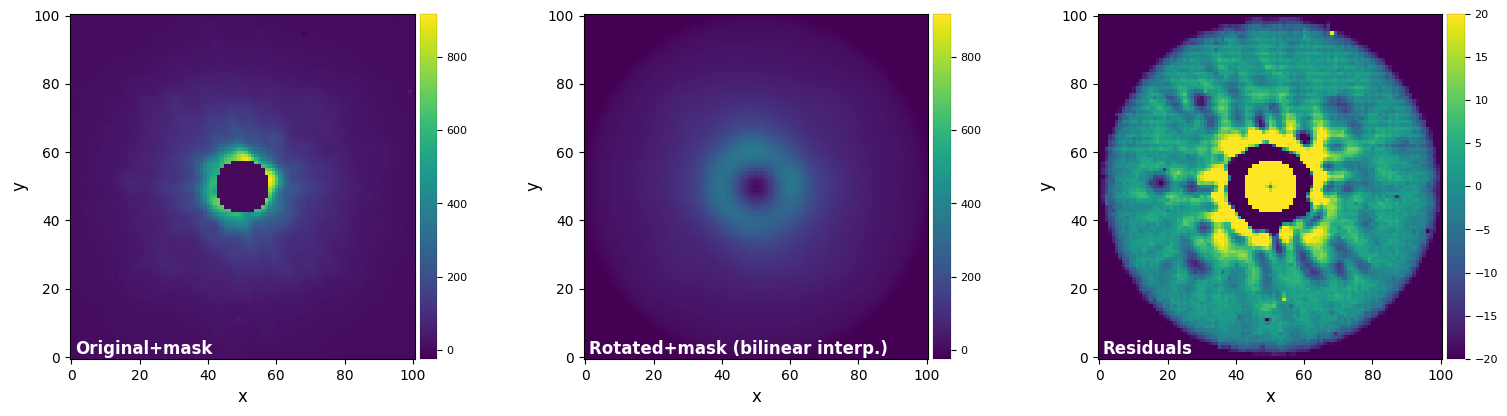

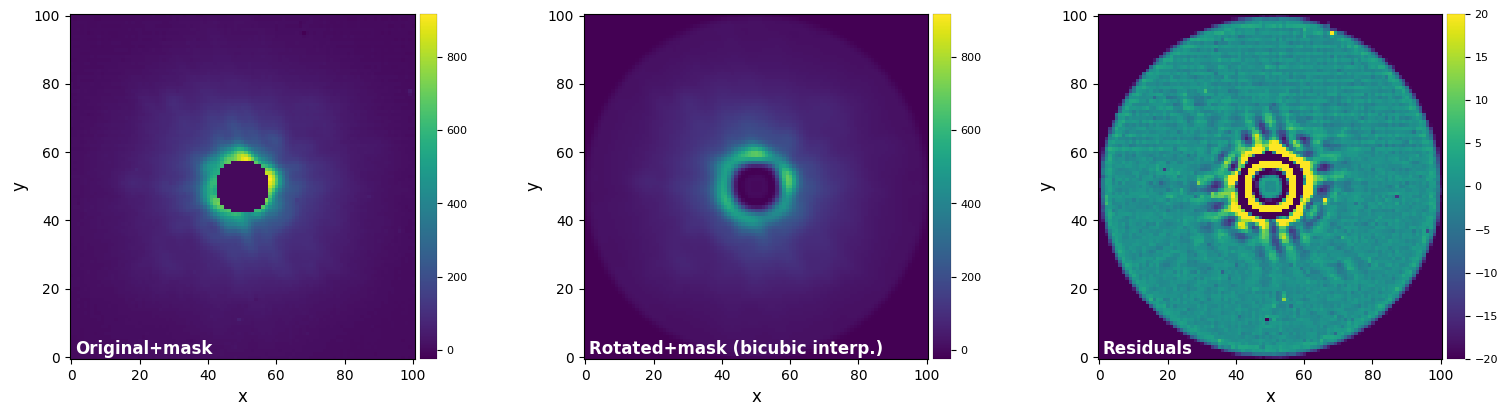

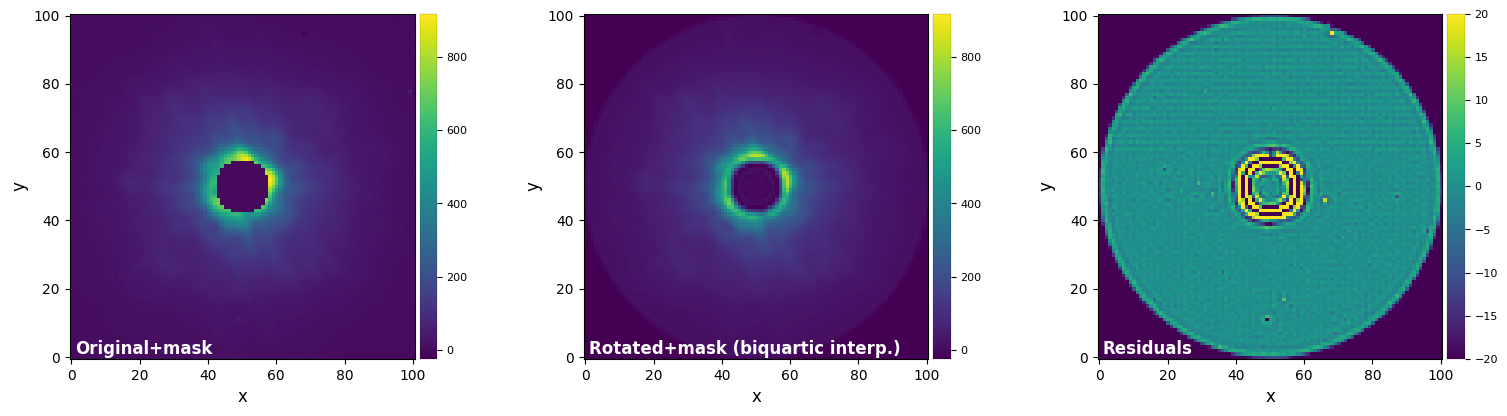

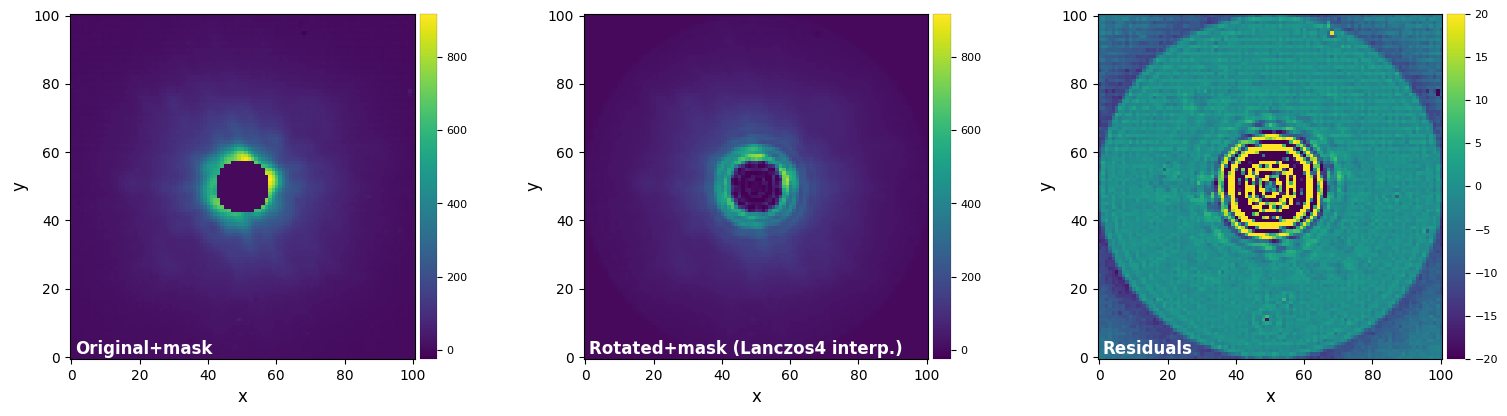

In [11]:
plot_frames((test_image_mask, test_image_rot_bil, test_image_rot_bil-test_image_mask),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original+mask", "Rotated+mask (bilinear interp.)", "Residuals"))
plot_frames((test_image_mask, test_image_rot_bic, test_image_rot_bic-test_image_mask),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original+mask", "Rotated+mask (bicubic interp.)", "Residuals"))
plot_frames((test_image_mask, test_image_rot_biq4, test_image_rot_biq4-test_image_mask),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original+mask", "Rotated+mask (biquartic interp.)", "Residuals"))
if not nocv2:
    plot_frames((test_image_mask, test_image_rot_lzs4, test_image_rot_lzs4-test_image_mask),
                 vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
                 label = ("Original+mask", "Rotated+mask (Lanczos4 interp.)", "Residuals"))

Notice both the artificial concentric rings and the non-zero residuals in the central masked area. The ringing artefacts are worse near the mask for higher interpolation orders. How would you solve the ringing artifact issue? Jump to [Section 8.2.3](#8.2.3.-Edge-blending) for one possible solution implemented in `VIP`.

### 8.2.2. FT-based method

A *shift* in the image plane corresponds to a multiplication by a phase factor in the Fourier plane. Furthermore [Larkin et al. 1997](https://ui.adsabs.harvard.edu/abs/1997OptCo.139...99L/abstract) demonstrated that *image rotation* could be decomposed into three consecutive 1D shears in the Fourier plane (along the x-, y- and x-axis again), i.e. by multiplication of the DFT of the image by a complex phase factor.

This method is implemented in `VIP`, and used in functions involving image rotations when `imlib` is set to 'vip-fft' (default).

Let's compare the results obtained with the biquintic interpolation and the FT-based method:

In [12]:
imlib_test = 'vip-fft'
interp = None

In [13]:
test_image_rot_fft = test_image.copy() 

print("*** FFT-based rotation test ***")
t0 = time_ini(False)
for i in range(72):
    test_image_rot_fft = frame_rotate(test_image_rot_fft, 5, imlib=imlib_test, interpolation=interp)
timing(t0)

*** FFT-based rotation test ***
Running time:  0:00:02.127505
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the results:

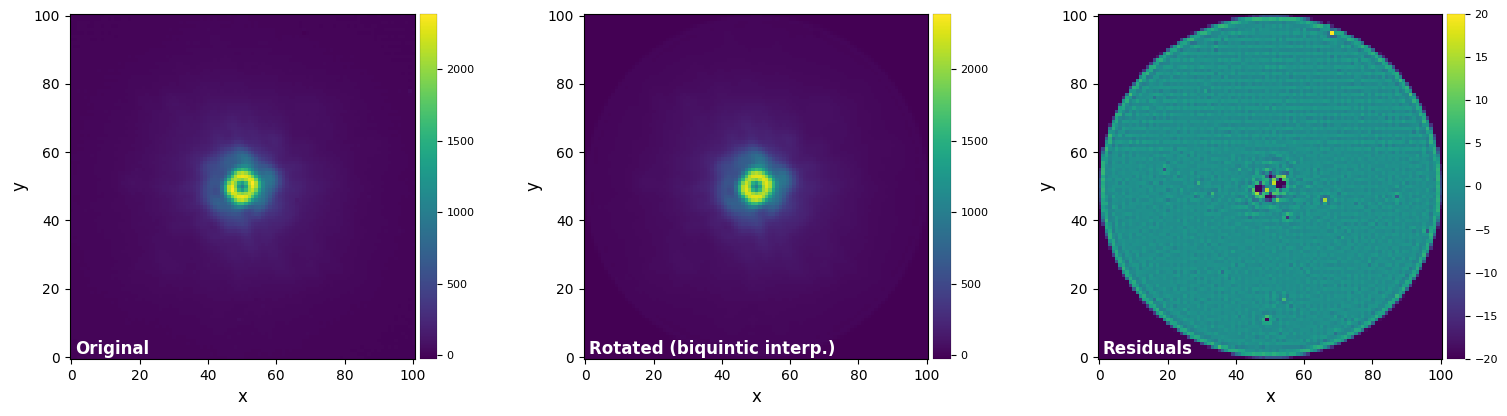

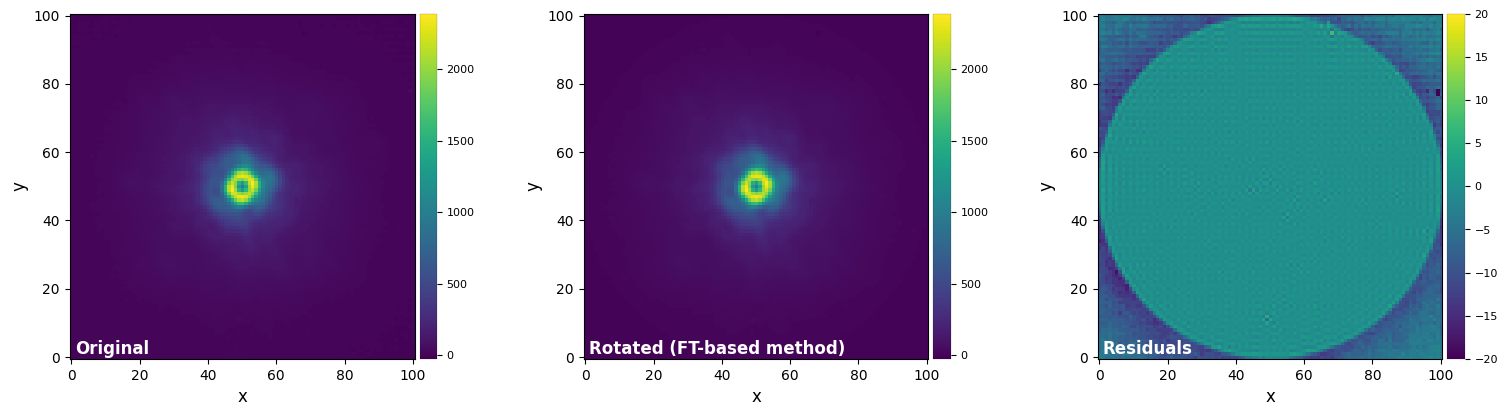

In [14]:
vmax12 = float(test_image.max())
vmin12 = float(test_image.min())

plot_frames((test_image, test_image_rot_biq5, test_image_rot_biq5-test_image),
             vmax=(vmax12, vmax12, vmax3), 
             vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "Rotated (biquintic interp.)", "Residuals"))
plot_frames((test_image, test_image_rot_fft, test_image_rot_fft-test_image),
             vmax=(vmax12, vmax12, vmax3), 
             vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "Rotated (FT-based method)", "Residuals"))

The comparison with the biquintic interpolation solution (the most accurate among our interpolation tests) reveals the clear superiority of the FT-based method to preserve the flux in the image, even after a large number of image rotations.

However, the last test also revealed a downside of the FT-based method: it is significantly slower than interpolation-based methods, due to the calculation of large and complex arrays (zero-padding is required before calculating the DFT making the arrays larger). For this toy dataset, the rotation test took ~50x (resp 8x) longer with the FT-based rotation than with `opencv`+Lanczos4 (resp. `skimage`+biquartic) interpolation. When using the `cube_derotate` function, it is recommended to use `nproc` to enable multiprocessing - i.e. parallel rotation of the images in the cube to significantly speed up the process.

Let's illustrate another downside of the FT-based method, by:

1) setting randomly a pixel as bad in the input image;

2) setting a numerical mask.

In [15]:
imlib_test = 'vip-fft'
interp = None

# bad pixel injected
bad_test_img = test_image.copy()
bad_test_img[30,30] = 3000 # let's inject randomly a single bad pixel
bad_test_rot_fft = frame_rotate(bad_test_img, 5, imlib=imlib_test, interpolation=interp)

# inner mask used
mask_test = mask_circle(test_image,4) # let's mask the inner 4 pixels of the image - i.e. replace them by 0
mask_test_rot_fft = frame_rotate(mask_test, 5, imlib=imlib_test, interpolation=interp)

Let's also adapt the cuts to better visualize the effect:

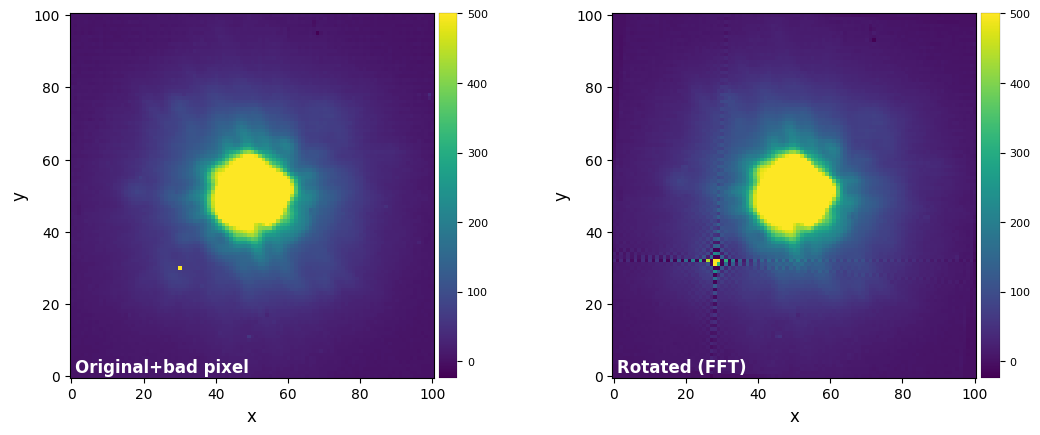

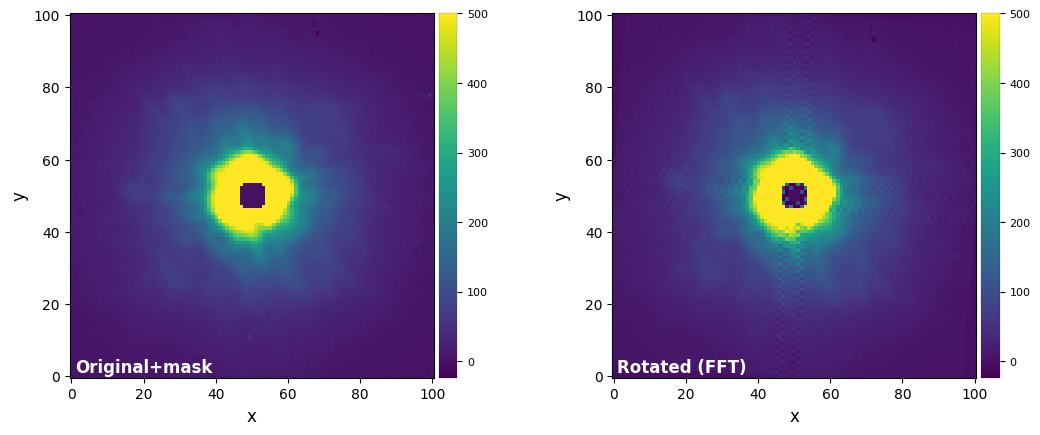

In [16]:
vmax12 = 500
vmin=0
plot_frames((bad_test_img, bad_test_rot_fft),
             vmax=(vmax12, vmax12), vmin=(vmin12, vmin12),
             label = ("Original+bad pixel", "Rotated (FFT)"))
plot_frames((mask_test, mask_test_rot_fft),
             vmax=(vmax12, vmax12), vmin=(vmin12,vmin12),
             label = ("Original+mask", "Rotated (FFT)"))

<font color=orange> **Question 8.2**: The test above shows that the FT-based rotation method can induce large-scale positive/negative artifacts plaguing significant portions of the rotated image, when either bad pixels or a numerical mask are present. Why is that so?  </font>

If the artifacts stem from bad pixels, the best solution is to either use one of `VIP`'s bad pixel correction algorithms beforehand (possibly with more stringent parameters for bad pixel correction; see `Tutorial 2`), or to slightly smooth the image afterwards (the latter may somewhat defeat the purpose of preserving flux though).

### 8.2.3. Edge-blending

If artifacts stem from an inner mask (for either high-order interpolation or FT-based methods), the `edge_blend` option can mitigate the effect of Gibbs artefacts. Edge-blending consists in replacing sharp edges to have a smoother transition. In this case, this is done using a Gaussian kernel to replace the mask values based on neighbouring intensity values (with the `astropy.convolution` module). After rotation, the original mask is then re-applied on the rotated image.

In [17]:
mask_test = mask_circle(test_image, 4)

# no edge-bleding
mask_test_rot_ski = frame_rotate(mask_test, 35, imlib='skimage', interpolation='biquartic')
mask_test_rot_fft = frame_rotate(mask_test, 35, imlib='vip-fft', interpolation=None)

# with edge-blending
mask_test_rot_ski_eb = frame_rotate(mask_test, 35, imlib='skimage', interpolation='biquartic', 
                                    mask_val=0, edge_blend='interp', interp_zeros=True, ker=1)

mask_test_rot_fft_eb = frame_rotate(mask_test, 35, imlib='vip-fft', interpolation=None, 
                                    mask_val=0, edge_blend='interp', interp_zeros=True, ker=1)

Let's visualize the results:

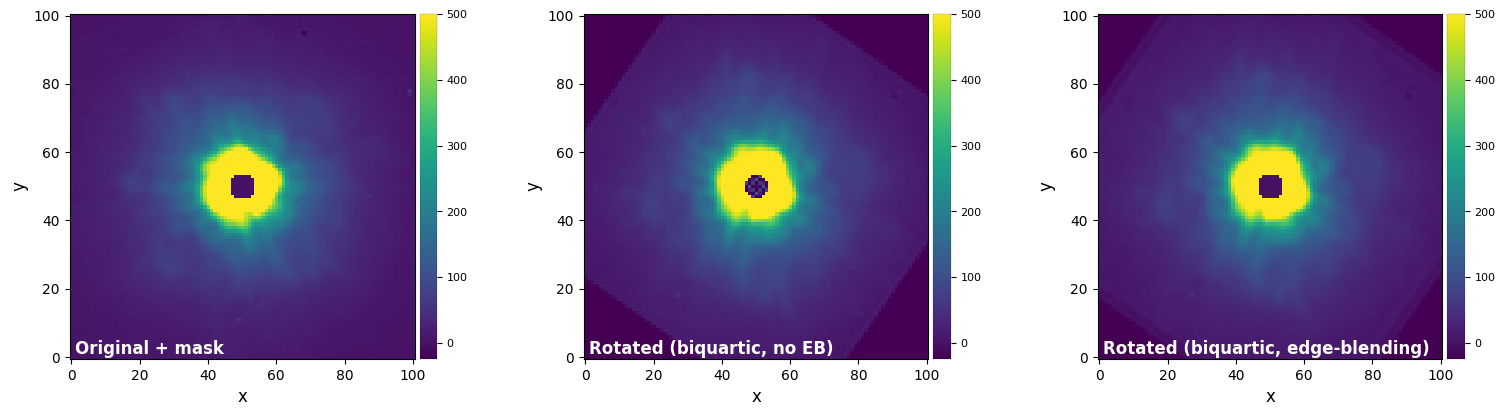

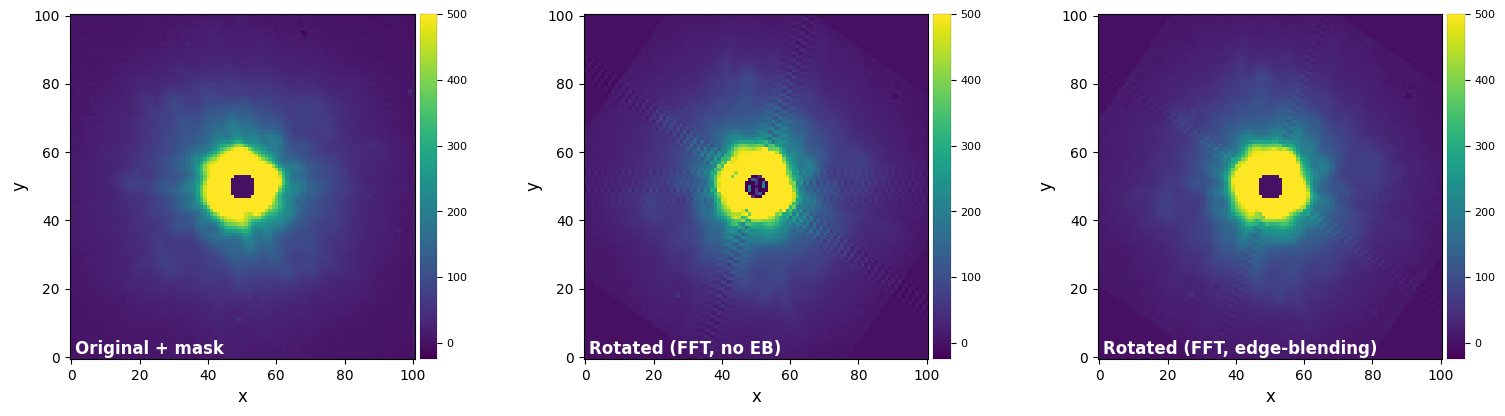

In [18]:
plot_frames((mask_test, mask_test_rot_ski, mask_test_rot_ski_eb),
            vmax=(vmax12,vmax12,vmax12), vmin=(vmin12,vmin12,vmin12),
            label = ("Original + mask", "Rotated (biquartic, no EB)", "Rotated (biquartic, edge-blending)"))

plot_frames((mask_test, mask_test_rot_fft, mask_test_rot_fft_eb),
            vmax=(vmax12,vmax12,vmax12), vmin=(vmin12,vmin12,vmin12),
            label = ("Original + mask", "Rotated (FFT, no EB)", "Rotated (FFT, edge-blending)"))

We can see that edge-blending worked well in both cases to significantly mitigate the artifacts that can be seen in the middle column.

The choice of method to use for image rotation, and whether to consider artifacts-mitigating strategies such as edge-blending eventually depends on the intensity distribution in the original image and the specific purpose of the rotated image (e.g. is accurate flux measurement or aesthetics more important?).

<font color=green> **Answer 8.2**: To understand why the FT-based method is very sensitive to singularities in the grid (e.g. bad/hot/cold pixels, or numerical mask), it is useful to remember that an image is nothing more than an equally-spaced 2D sample from an intensity distribution. The FT-based method involves the calculation of both discrete Fourier Transform (DFT) and inverse DFT (note aside: both are typically calculated with a fast-Fourier transform - such that DFT and FFT are often used interchangeably). Calculating the DFT is equivalent to finding the coefficients of a truncated Fourier series. The artefacts stem from the fact that either a step-edge or a Dirac signal require on the contrary an *infinite* Fourier series to be perfectly represented. In turn, the inverse DFT of this truncated Fourier series (sinusoid in 1D) leads to Gibbs artifacts plaguing the rotated image.</font>

## 8.3. Scaling

To evaluate how well the flux is preserved by each method in the case of image scaling, we scale the image up 18 times by 1.10,1.11,...,1.27, and then scale it down by their inverse, then compare the resulting image to the original image. The available options for `imlib` in the case of *image scaling* are:

- `'opencv'` to use the `opencv` python package (optional dependency);
- `'ndimage'` to use functions of the `scipy-ndimage` package;
- `'vip-fft'` to use a FT-based scaling method implemented in VIP.

If imlib is set to `opencv` or `ndimage`, the `interpolation` argument will set the degree of interpolation to be used - check the description of `vip.preproc.frame_px_resampling` for all available options.

### 8.3.1. Interpolation-based methods

Define scaling factors and their inverse:

In [19]:
imlib_test = 'ndimage'
scal_facs_up = [1.1+(0.01*i) for i in range(18)]
scal_facs_down = [1/(1.1+(0.01*i)) for i in range(17,-1,-1)]
scal_facs = scal_facs_up+scal_facs_down
print(scal_facs)

[1.1, 1.11, 1.12, 1.1300000000000001, 1.1400000000000001, 1.1500000000000001, 1.1600000000000001, 1.1700000000000002, 1.1800000000000002, 1.1900000000000002, 1.2000000000000002, 1.2100000000000002, 1.2200000000000002, 1.23, 1.2400000000000002, 1.25, 1.26, 1.27, 0.7874015748031495, 0.7936507936507936, 0.8, 0.8064516129032256, 0.8130081300813008, 0.8196721311475409, 0.8264462809917354, 0.8333333333333333, 0.8403361344537814, 0.8474576271186439, 0.8547008547008546, 0.8620689655172413, 0.8695652173913042, 0.8771929824561403, 0.8849557522123893, 0.8928571428571428, 0.9009009009009008, 0.9090909090909091]


Perform the scaling with different interpolation orders:

In [20]:
from vip_hci.preproc import frame_px_resampling

test_image_sc_bil = test_image.copy()
test_image_sc_bic = test_image.copy()
test_image_sc_biq = test_image.copy()
test_image_sc_biq5 = test_image.copy()

print("*** Bilinear ({}) test ***".format(imlib_test))
t0 = time_ini(False)
for i in range(len(scal_facs)):
    test_image_sc_bil = frame_px_resampling(test_image_sc_bil, scale=scal_facs[i],
                                            imlib=imlib_test, interpolation='bilinear')
timing(t0) 
    
print("*** Bicubic ({}) test ***".format(imlib_test))
t0 = time_ini(False)
for i in range(len(scal_facs)):
    test_image_sc_bic = frame_px_resampling(test_image_sc_bic, scale=scal_facs[i],
                                            imlib=imlib_test, interpolation='bicubic')
timing(t0) 

print("*** Biquartic ({}) test ***".format(imlib_test))
t0 = time_ini(False)
for i in range(len(scal_facs)):
    test_image_sc_biq = frame_px_resampling(test_image_sc_biq, scale=scal_facs[i],
                                            imlib=imlib_test, interpolation='biquartic')
timing(t0)
   
print("*** Biquintic ({}) test ***".format(imlib_test))
t0 = time_ini(False)
for i in range(len(scal_facs)):
    test_image_sc_biq5 = frame_px_resampling(test_image_sc_biq5, scale=scal_facs[i],
                                             imlib=imlib_test, interpolation='biquintic')
timing(t0)

*** Bilinear (ndimage) test ***
Running time:  0:00:00.276996
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Bicubic (ndimage) test ***
Running time:  0:00:01.291220
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Biquartic (ndimage) test ***
Running time:  0:00:02.027138
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Biquintic (ndimage) test ***
Running time:  0:00:02.499934
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's set the cuts for the images to be displayed

In [21]:
vmax12 = float(test_image.max())
vmax3 = 3
vmin12 = float(test_image.min())
vmin3 = -3

Let's visualize the results:

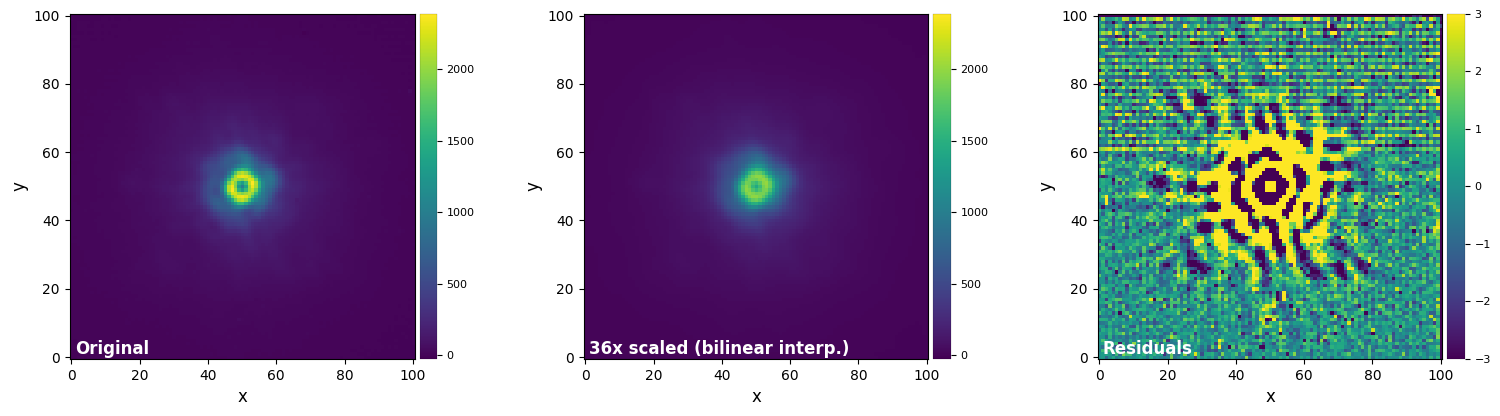

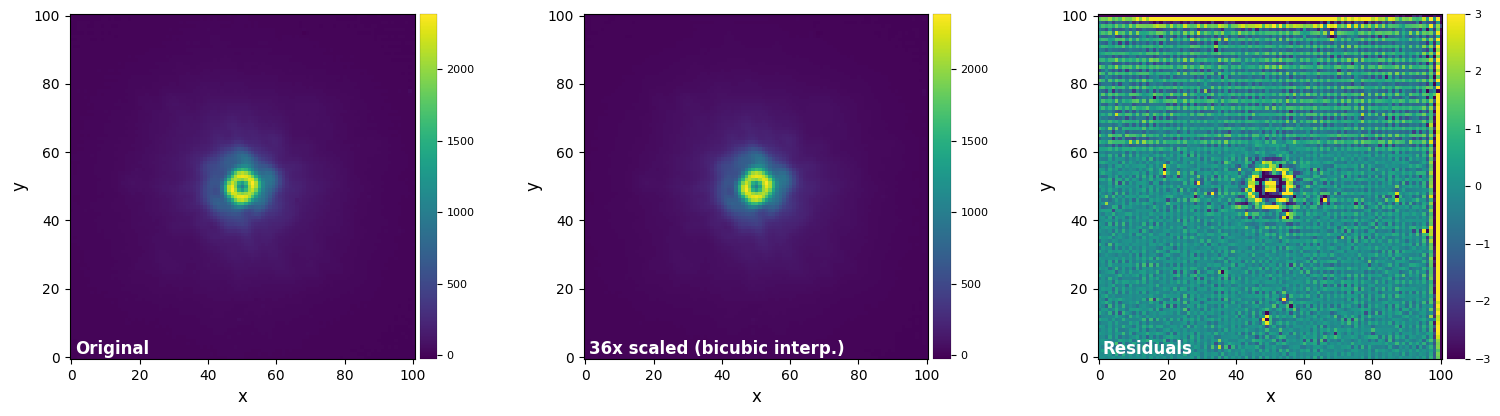

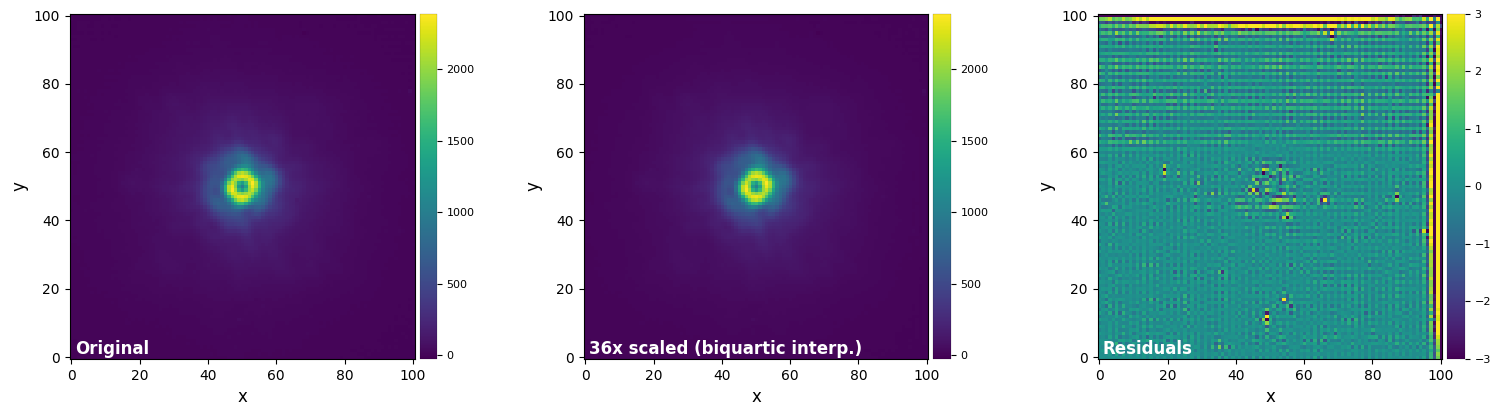

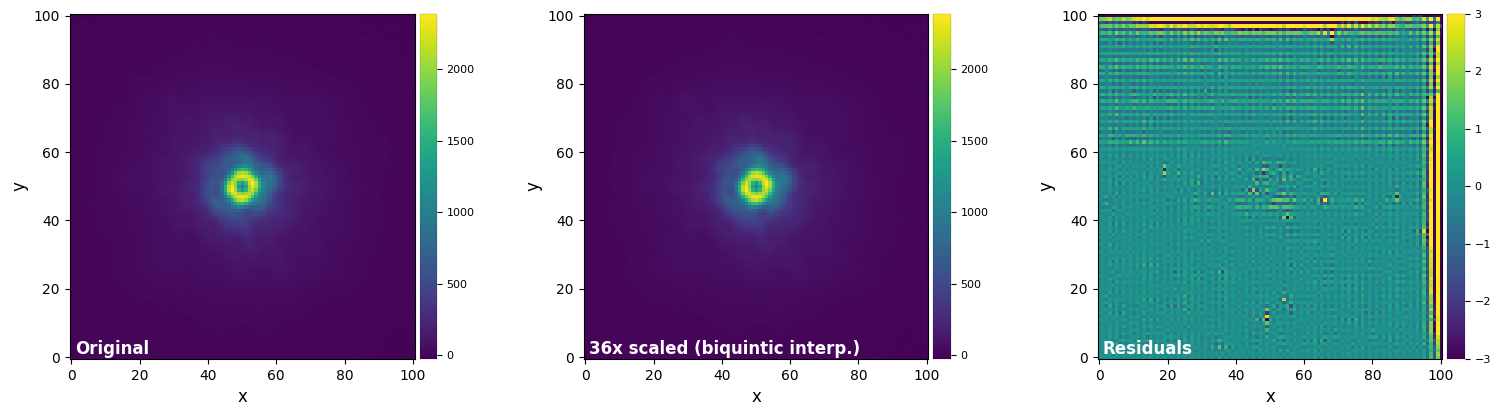

In [22]:
plot_frames((test_image, test_image_sc_bil, test_image_sc_bil-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "36x scaled (bilinear interp.)", "Residuals"))
plot_frames((test_image, test_image_sc_bic, test_image_sc_bic-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "36x scaled (bicubic interp.)", "Residuals"))
plot_frames((test_image, test_image_sc_biq, test_image_sc_biq-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "36x scaled (biquartic interp.)", "Residuals"))
plot_frames((test_image, test_image_sc_biq5, test_image_sc_biq5-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "36x scaled (biquintic interp.)", "Residuals"))

Interpolation-based methods are relatively fast, with the degree of interpolation usually setting the trade-off between flux conservation (higher orders more accurate) and speed (lower orders faster).

Let's now test interpolation-based rotation using `opencv`, if installed:

*** Bilinear (opencv) test ***
Running time:  0:00:00.041909
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Bicubic (opencv) test ***
Running time:  0:00:00.036568
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Lanczos4 (opencv) test ***
Running time:  0:00:00.043609
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


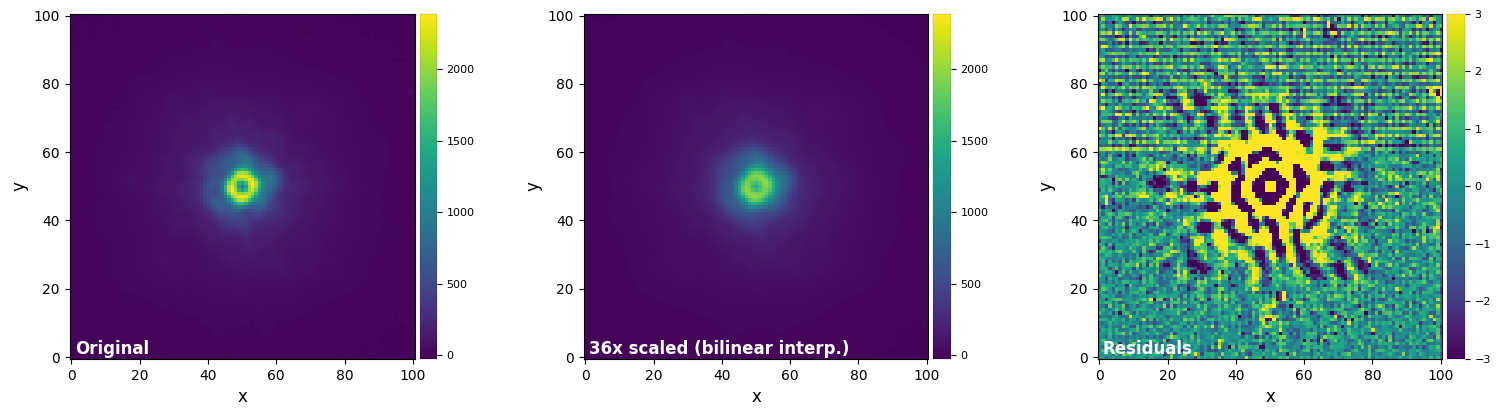

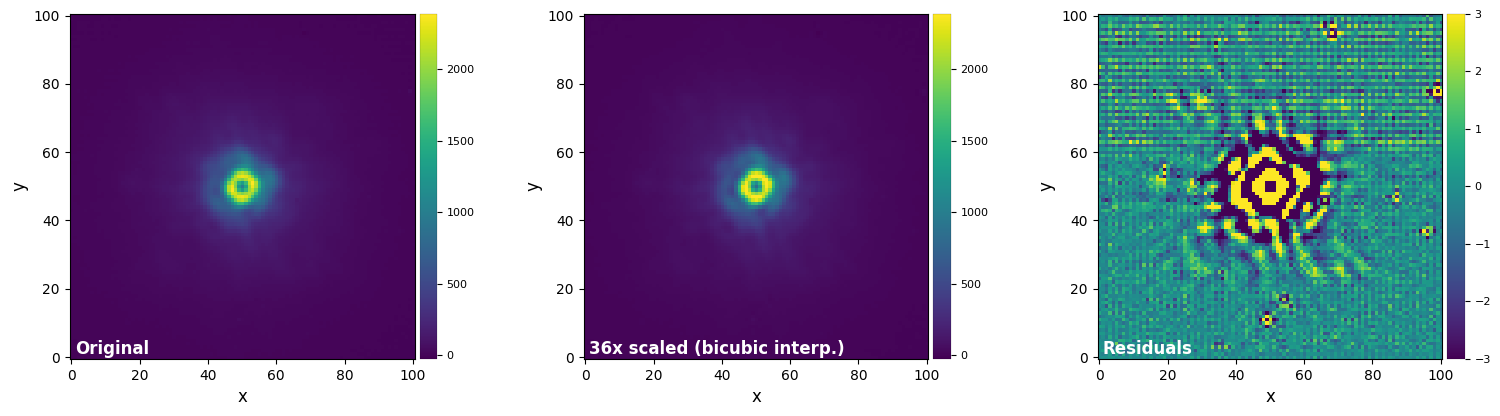

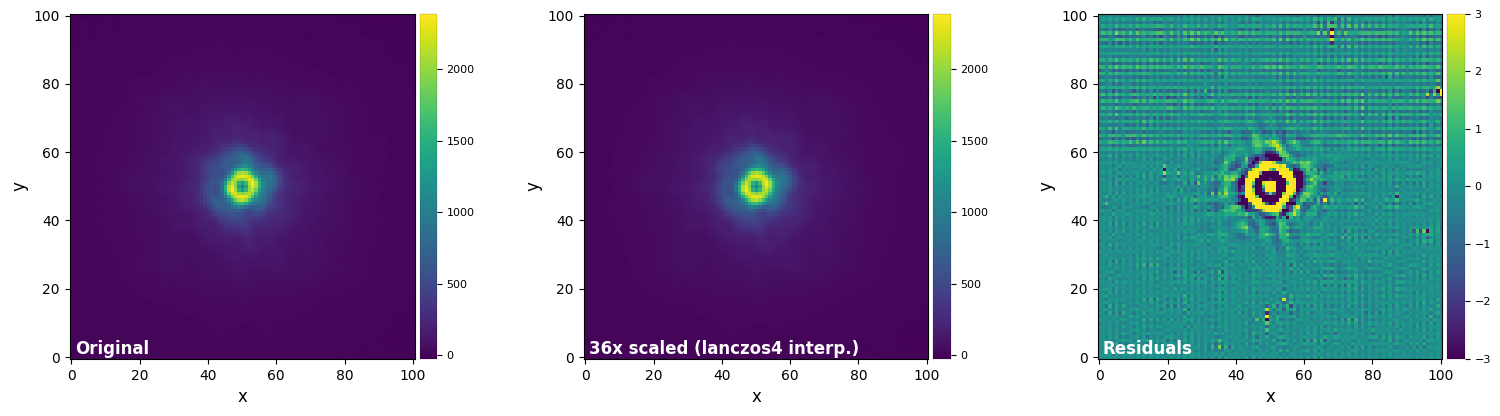

In [23]:
if not nocv2:
    imlib_test = 'opencv'

    test_image_sc_bil = test_image.copy()
    test_image_sc_bic = test_image.copy()
    test_image_sc_lzs4 = test_image.copy()

    print("*** Bilinear ({}) test ***".format(imlib_test))
    t0 = time_ini(False)
    for i in range(len(scal_facs)):
        test_image_sc_bil = frame_px_resampling(test_image_sc_bil, scale=scal_facs[i],
                                                 imlib=imlib_test, interpolation='bilinear')
    timing(t0) 

    print("*** Bicubic ({}) test ***".format(imlib_test))
    t0 = time_ini(False)
    for i in range(len(scal_facs)):
        test_image_sc_bic = frame_px_resampling(test_image_sc_bic, scale=scal_facs[i],
                                                imlib=imlib_test, interpolation='bicubic')
    timing(t0) 

    t0 = time_ini(False)
    print("*** Lanczos4 ({}) test ***".format(imlib_test))
    for i in range(len(scal_facs)):
        test_image_sc_lzs4 = frame_px_resampling(test_image_sc_lzs4, scale=scal_facs[i],
                                                imlib=imlib_test, interpolation='lanczos4')
    timing(t0)
    
    plot_frames((test_image, test_image_sc_bil, test_image_sc_bil-test_image),
                 vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
                 label = ("Original", "36x scaled (bilinear interp.)", "Residuals"))
    plot_frames((test_image, test_image_sc_bic, test_image_sc_bic-test_image),
                 vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
                 label = ("Original", "36x scaled (bicubic interp.)", "Residuals"))
    plot_frames((test_image, test_image_sc_lzs4, test_image_sc_lzs4-test_image),
                 vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
                 label = ("Original", "36x scaled (lanczos4 interp.)", "Residuals"))

Using the `opencv` library yields significantly faster speeds (an order of magnitude faster) than `ndimage`, but an overall decrease in accuracy.

As in the rotation tests, the presence of high-spatial frequency or step-edge like signals (e.g. numerical or physical coronagraphic mask), higher order interpolation can lead to ringing artefacts.

### 8.3.2. FT-based method

When *scaling* an image by a given multiplicative factor, the Fourier transform is affected by the inverse scaling factor. For a desired scaling factor f, one can search among $i/f$ for $i \in [1,...,N/2]$ for the value closest to an integer, and use it to perform the scaling of the input image via an inverse scaling of its Fourier transform. This is done in the ``vip.preproc.scale_fft`` function, which is called by the wrapper functions ``frame_px_resampling`` or ``frame_rescaling`` if ``imlib`` is set to 'vip-fft'.

The FT-based method for image scaling is only available in VIP v1.0.1 and above.

In [24]:
imlib_test = 'vip-fft'
interp = None
test_image_sc_fft = test_image.copy()

print("*** FFT-based scaling test ***")
t0 = time_ini(False)
for i in range(len(scal_facs)):
    print("shape (it. {:.0f}): {:.0f}x{:.0f}".format(i, test_image_sc_fft.shape[0], test_image_sc_fft.shape[1]))
    test_image_sc_fft = frame_px_resampling(test_image_sc_fft, scale=scal_facs[i],
                                            imlib=imlib_test, interpolation=interp)
print("shape (it. {:.0f}): {:.0f}x{:.0f}".format(i+1, test_image_sc_fft.shape[0], test_image_sc_fft.shape[1]))
timing(t0)

*** FFT-based scaling test ***
shape (it. 0): 101x101
shape (it. 1): 111x111
shape (it. 2): 123x123
shape (it. 3): 139x139
shape (it. 4): 157x157
shape (it. 5): 179x179
shape (it. 6): 207x207
shape (it. 7): 241x241
shape (it. 8): 283x283
shape (it. 9): 335x335
shape (it. 10): 399x399
shape (it. 11): 479x479
shape (it. 12): 581x581
shape (it. 13): 709x709
shape (it. 14): 873x873
shape (it. 15): 1083x1083
shape (it. 16): 1355x1355
shape (it. 17): 1709x1709
shape (it. 18): 2171x2171
shape (it. 19): 1709x1709
shape (it. 20): 1355x1355
shape (it. 21): 1083x1083
shape (it. 22): 873x873
shape (it. 23): 709x709
shape (it. 24): 581x581
shape (it. 25): 479x479
shape (it. 26): 399x399
shape (it. 27): 335x335
shape (it. 28): 283x283
shape (it. 29): 241x241
shape (it. 30): 207x207
shape (it. 31): 179x179
shape (it. 32): 157x157
shape (it. 33): 139x139
shape (it. 34): 123x123
shape (it. 35): 111x111
shape (it. 36): 101x101
Running time:  0:00:01.631262
―――――――――――――――――――――――――――――――――――――――――――――――

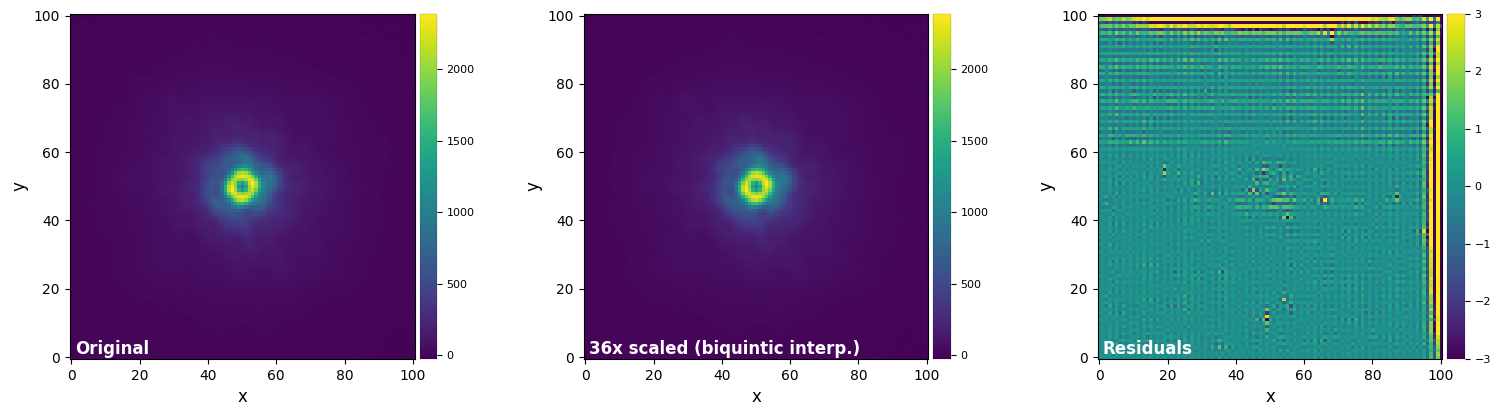

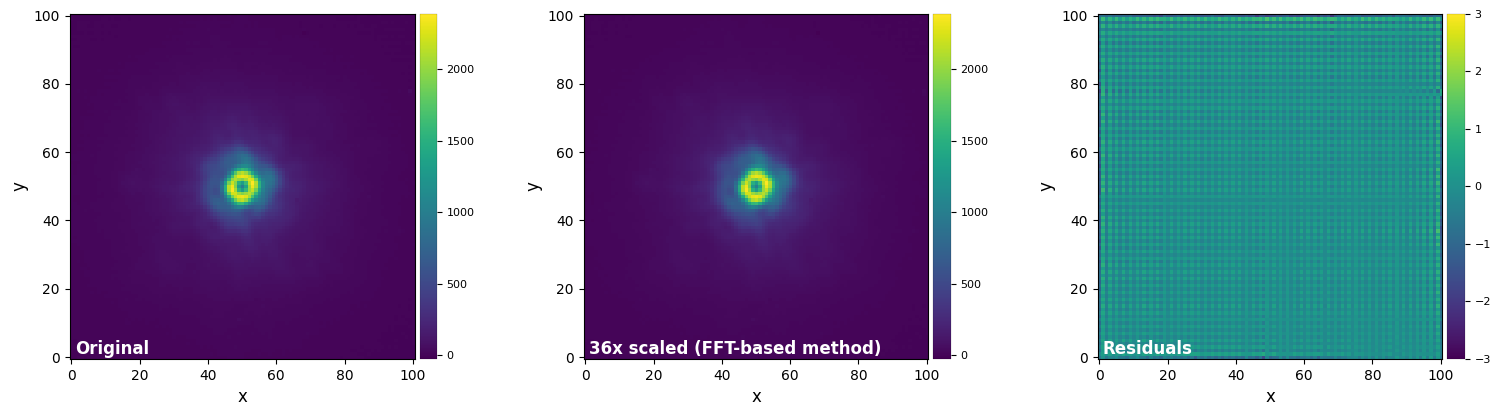

In [25]:
vmax12 = float(test_image.max())
vmin12 = float(test_image.min())

plot_frames((test_image, test_image_sc_biq5, test_image_sc_biq5-test_image),
             vmax=(vmax12, vmax12, vmax3), 
             vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "36x scaled (biquintic interp.)", "Residuals"))

plot_frames((test_image, test_image_sc_fft, test_image_sc_fft-test_image),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "36x scaled (FFT-based method)", "Residuals"))

As in the rotation tests, the FFT-based method appears slightly superior to the highest-order interpolation-based methods. This time the computation times are similar though (at least compared to the `skimage` biquartic and biquintic interpolations).

## 8.4. Shifts

Although the previous tests focused on image rotation and scaling only, similar tests could be performed with *sub-px shifts*, using `frame_shift`. In the latter case, the available options for `imlib` (i.e. in the recentering functions) are:

- `opencv` to use the opencv python package;
- `ndimage-interp` to use functions of the scipy ndimage package; 
- `ndimage-fourier` or `vip-fft` to use the FFT-based shift function implemented in scipy ndimage.

This time let's consider 20 consecutive shifts, such that their sum is 0.

In [26]:
imlib_test = 'ndimage-interp'
shifts = [(1.1+(0.01*(i-1)))*(1j**i).real for i in range(2,40,2)]
shifts = shifts+[-np.sum(shifts)]
print(shifts)

[-1.11, 1.1300000000000001, -1.1500000000000001, 1.1700000000000002, -1.1900000000000002, 1.2100000000000002, -1.23, 1.25, -1.27, 1.29, -1.31, 1.33, -1.35, 1.37, -1.3900000000000001, 1.4100000000000001, -1.4300000000000002, 1.4500000000000002, -1.4700000000000002, 1.29]


Let's consider the highest-order interpolation with `skimage`, which based on previous tests, leads to the best results (among interpolation-based methods).

In [27]:
from vip_hci.preproc import frame_shift

test_image_sh_biq5 = test_image.copy()
   
print("*** Biquintic ({}) test ***".format(imlib_test))
t0 = time_ini(False)
for i in range(len(shifts)):
    test_image_sh_biq5 = frame_shift(test_image_sh_biq5, shifts[i], shifts[-i], 
                                      imlib=imlib_test, interpolation='biquintic')
timing(t0)

*** Biquintic (ndimage-interp) test ***
Running time:  0:00:00.029520
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now let's consider the FT-based shifting method:

In [28]:
imlib_test = 'vip-fft' #note: 'ndimage-fourier' leads to the same results
interp = None
test_image_crop = test_image[:-1,:-1]
test_image_sh_fft = test_image_crop.copy()

print("*** FFT-based shift test ***")
t0 = time_ini(False)
for i in range(len(shifts)):
    test_image_sh_fft = frame_shift(test_image_sh_fft, shifts[i], shifts[-i], imlib=imlib_test)
timing(t0)

*** FFT-based shift test ***
Running time:  0:00:00.011807
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's compare both:

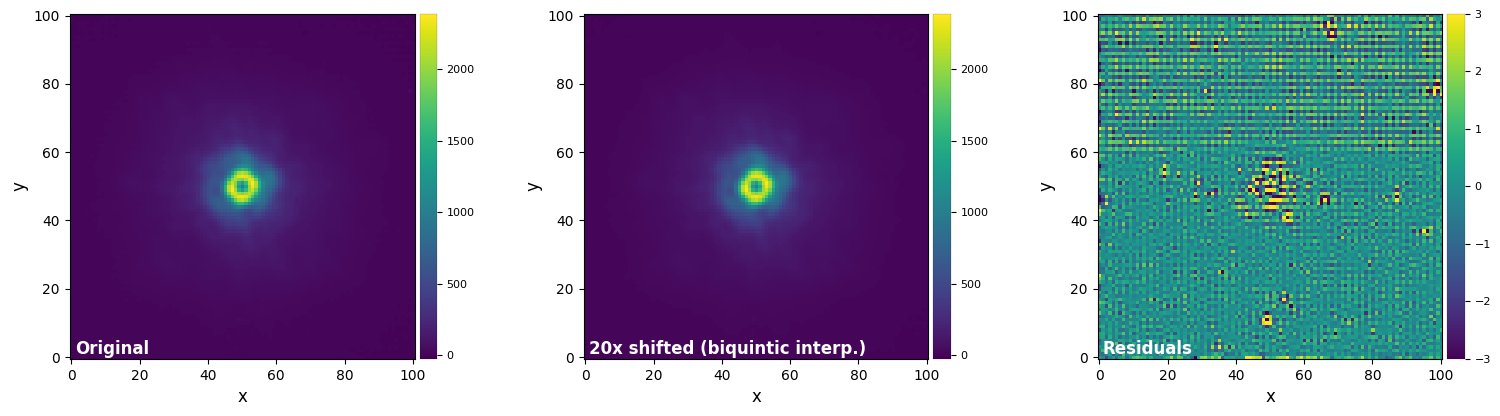

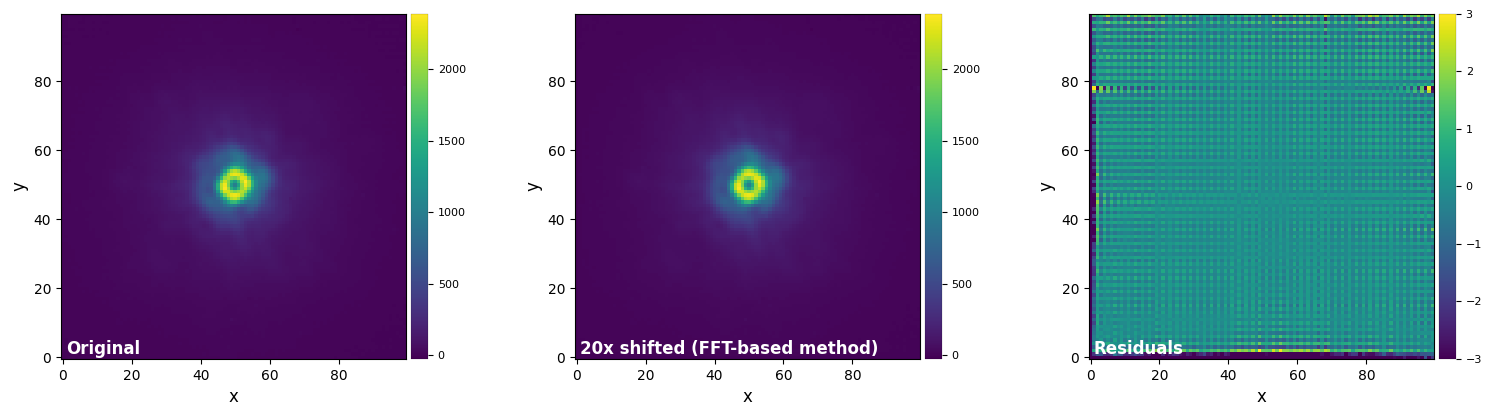

In [29]:
vmax12 = float(test_image.max())
vmin12 = float(test_image.min())

plot_frames((test_image, test_image_sh_biq5, test_image_sh_biq5-test_image),
             vmax=(vmax12, vmax12, vmax3), 
             vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "20x shifted (biquintic interp.)", "Residuals"))

plot_frames((test_image_crop, test_image_sh_fft, test_image_sh_fft-test_image_crop),
             vmax=(vmax12, vmax12, vmax3), vmin=(vmin12, vmin12, vmin3),
             label = ("Original", "20x shifted (FFT-based method)", "Residuals"))

Again, the FFT-based method appears slightly superior to the highest-order interpolation-based methods, for a similar or slightly faster computation time.

All the tests shown in this tutorial motivates the change made for the default method adopted throughout VIP for image shifts, scaling and rotation. Starting from VIP v1.0.2, the default method is now `'vip-fft'`.